# Movie Recommender System

A recommender system is a system that attempts to predict the rating or preference a user would give to a certain item.
In this case, it is intended to create a movie recommender system.

A popular algorithm for these kind of systems is the Singular Value Decomposition (SVD), that has been utilized to achieve better results, as it will be demonstrated ahead.

## Dataset

The MovieLens Dataset is most often used for the purpose of recommender systems, which aim to predict user movie ratings based on other users’ ratings.

The data was collected through the MovieLens web site (movielens.umn.edu) during the seven-month period from September 19th, 1997 through April 22nd, 1998. This data has been cleaned up - users who had less than 20 ratings or did not have complete demographic information were removed from this data set.

The data are contained in the files:
- Movies.csv: movieId, title, genres.
- Ratings.csv: userId, movieId, rating, timestamp.
- Tags.csv: userId, movieId, tag, timestamp.

In [6]:
# Import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from funk_svd.dataset import fetch_ml_ratings
from funk_svd import SVD
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

## Load Movie Data

First, it is necessary to load the file that contains information about a movie identified by its ID. There is a total of 1682 movies.

In [7]:
# Read Movie Data
i_cols = ['movie_id', 'title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('ml-100k/u.item',  sep='|', names=i_cols, encoding='latin-1')

print(movies.head())

num_movies = len(movies)

print(f"Number of movies: {num_movies}")

   movie_id              title release date  video release date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)        0       0   

   Adventure  Animation  Children's  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1           1  ...        0          0       0        0

## Load User Data

Then, do the same process but for the user data.

In [8]:
# user
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

print(users.head())

num_users = len(users)

print(f"Number of users: {num_users}")

   user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
1        2   53   F       other    94043
2        3   23   M      writer    32067
3        4   24   M  technician    43537
4        5   33   F       other    15213
Number of users: 943


# Load Ratings Data

Finally, load the ratings that the users gave to movies. Here, it is possible to see that it was loaded all the 100 000 ratings, and other statistics such as the mean rating, that is 3.529860.

In [9]:
# Ratings
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=r_cols, encoding='latin-1')

print(ratings.head())

print(ratings.describe())

print(len(ratings.user_id.unique()))
print(len(ratings.movie_id.unique()))

   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
            user_id       movie_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08
943
1682


## Sparsity

The Sparsity of a matrix is measured by the number of cells that do not have a value.
As it can be seen bellow, the matrix of ratings in this dataset is going to be very sparse, having a sparsity of 93.7%,
which means that the majority of users only rated a small percentage of the movies.

In [10]:
sparsity = 1 - len(ratings) / (num_users * num_movies)

print(f"Sparsity: {sparsity:.3f}")

Sparsity: 0.937


# Data Analysis

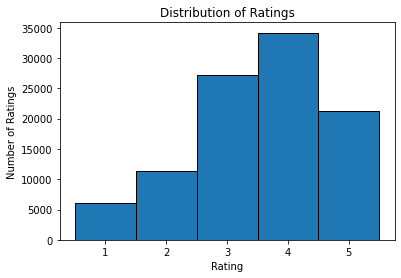

In [11]:
plt.hist(ratings.rating, ec='black', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Ratings")
plt.xticks([1, 2, 3, 4, 5])
plt.show()

## Construct Matrix

In [12]:
ratings_matrix = ratings.pivot(index="user_id", columns="movie_id", values="rating")

print(ratings_matrix.shape)
print(ratings_matrix.iloc[:5, :5])

(943, 1682)
movie_id    1    2    3    4    5
user_id                          
1         5.0  3.0  4.0  3.0  3.0
2         4.0  NaN  NaN  NaN  NaN
3         NaN  NaN  NaN  NaN  NaN
4         NaN  NaN  NaN  NaN  NaN
5         4.0  3.0  NaN  NaN  NaN


# Filling the Matrix
As it can be seen above, there are NaN entries on the matrix, which need to be replaced by some other value in order to perform the SVD.

There are several approaches to this problem, such as replacing with zero value, or average of all ratings, or even the average rating of a user.

In [13]:
mean_rating = np.mean(ratings.rating)
print(mean_rating)
ratings_matrix_mean = ratings_matrix.fillna(mean_rating)
print(ratings_matrix_mean.iloc[:5, :5])

ratings_matrix = ratings_matrix.fillna(0)
print(ratings_matrix.iloc[:5, :5])

3.52986
movie_id        1        2        3        4        5
user_id                                              
1         5.00000  3.00000  4.00000  3.00000  3.00000
2         4.00000  3.52986  3.52986  3.52986  3.52986
3         3.52986  3.52986  3.52986  3.52986  3.52986
4         3.52986  3.52986  3.52986  3.52986  3.52986
5         4.00000  3.00000  3.52986  3.52986  3.52986
movie_id    1    2    3    4    5
user_id                          
1         5.0  3.0  4.0  3.0  3.0
2         4.0  0.0  0.0  0.0  0.0
3         0.0  0.0  0.0  0.0  0.0
4         0.0  0.0  0.0  0.0  0.0
5         4.0  3.0  0.0  0.0  0.0


The sparsity mentioned above, can be verified by the percentage of zeros present in the matrix.

In [14]:
sparsity = 1 - np.count_nonzero(ratings_matrix) / (num_users * num_movies)
print(f"Sparsity: {sparsity:.3f}")

Sparsity: 0.937


# SVD

The SVD, Singular Value decomposition, its a technique that allows the factorization of the matrix data into a multiplication between three matrices, U, Sigma and V. The columns of the matrix U are considered the singular vectors on the left and the columns of the matrix V are the singular vectors on the right. Sigma has the singular values ​​diagonally.
SVD contains some important properties:
- It is always possible to decompose any matrix A into three matrices: U, Sigma and V.
- U, Sigma and V are always unique matrices, which means that a set of U, Sigma and V represents a single matrix A.
- U and V have orthonormal columns, which means that by multiplying the transpose of U with U, an identity matrix is ​​obtained.
- The sigma matrix is ​​diagonal, which means that all non-diagonal values ​​have zero value. The diagonal entries of this matrix are always positive, and by convention they are sorted in descending order. 

In [15]:
#TODO:
# Get a few data for tests and then replace on train matrix
# also do ratings_matrix = ratings_matrix.fillna(x) with x equal to the mean global rating
# and then predict for a trained rating and untrained rating

U, S, VT = np.linalg.svd(ratings_matrix, full_matrices=False)

print(f"U: {pd.DataFrame(U).iloc[:5, :5]}")
print(f"S: {pd.DataFrame(S).iloc[:5, :]}")
print(f"VT: {pd.DataFrame(VT).iloc[:5, :5]}")
print(U.shape)
print(S.shape)
print(VT.shape)

U:           0         1         2         3         4
0 -0.065804  0.005975 -0.006133  0.084347 -0.014188
1 -0.014021 -0.046626  0.052579 -0.016282  0.015467
2 -0.005658 -0.025618  0.023362 -0.028564 -0.044057
3 -0.005993 -0.020698  0.012452 -0.019697 -0.025116
4 -0.032747  0.009159 -0.046131  0.014407 -0.010518
S:             0
0  640.633623
1  244.836346
2  217.846225
3  159.153599
4  158.211914
VT:           0         1         2         3         4
0 -0.095951 -0.035180 -0.019929 -0.059952 -0.021607
1 -0.087240 -0.007025 -0.028618  0.013050 -0.015311
2 -0.016974 -0.062504 -0.011641 -0.026446 -0.026460
3  0.016206  0.003234  0.048801  0.043000  0.017901
4  0.140506 -0.040758 -0.004402 -0.038221 -0.015655
(943, 943)
(943,)
(943, 1682)


## SVD Matrix Reconstruction

The factorization of the matrixes U, Sigma and V will allow make an aproximation to the original matrix. Thus, we are able to reconstruct this matrix resulting in very small error values, as it is shown below. 

In [16]:
reconstructed_matrix = np.dot(U * S, VT)

print(reconstructed_matrix[1][:4])
print(ratings_matrix.iloc[1, :4].to_numpy())

mae = np.average(np.absolute(ratings_matrix - reconstructed_matrix))
mse = np.average((ratings_matrix - reconstructed_matrix) ** 2)
rmse = math.sqrt(mse)
print("Reconstruction Mean Absolute Error: ", mae)
print("Reconstruction Mean Square Error: ", mse)
print("Reconstruction Root Mean Square Error: ", rmse)

[4.00000000e+00 3.42524620e-13 2.72351586e-14 6.08471606e-14]
[4. 0. 0. 0.]
Reconstruction Mean Absolute Error:  1.850350696539756e-15
Reconstruction Mean Square Error:  1.0279565730740995e-29
Reconstruction Root Mean Square Error:  3.20617618523078e-15


## Truncated SVD
SVD establishes linear relationships between data that best describe them.

Through the singular values ​​obtained in the matrix S, which are indicators of the weight of each latent factor, we can choose R latent factors, which as the matrix is ​​ordered in descending order, we can only get the first values.

This dimension reduction technique is called Truncated SVD.

Truncated SVD allows the increasing of the performance of the system, and also the reduction of the overfit of a trained model, since latent factors with little weight can be seen as noise.

We may reconstruct the matrix using 10 latent factors, for example, as it can be verified bellow. As expected the errors obtained are way higher than the previous ones.

In [17]:
reconstructed_matrix = np.dot(U[:,:10] * S[:10], VT[:10,:])
mae = np.average(np.absolute(ratings_matrix - reconstructed_matrix))
mse = np.average((ratings_matrix - reconstructed_matrix) ** 2)
rmse = math.sqrt(mse)
print("Reconstruction Mean Absolute Error: ", mae)
print("Reconstruction Mean Square Error: ", mse)
print("Reconstruction Root Mean Square Error: ", rmse)

Reconstruction Mean Absolute Error:  0.28828730113395534
Reconstruction Mean Square Error:  0.46087448189914654
Reconstruction Root Mean Square Error:  0.6788773688223423


## Funk SVD

Funk SVD uses Stocasthic Gradient Descent(SGD) in order to obtain the matrices U and V. 

SGD uses labled data as training and tries to minimize the error of the model when predicting to another set, the validation set.

The training set is obtained from the data by choosing randomly 80% of the ratings. The 20% left are split into validation and test set. 
The SVD model is trained for multiple epochs using the training set data. In order to see if the model is doing great it needs to be compared
to data that it as not seen yet, the validation set. The test set is used to obtain the final error of the model.



During the training there are a few parameters that can be adjusted in order to obtain better and/or faster results. 

- The learning rate, tells the model how much it can update the "weights" from one step to the other. Usually its a value between 0 and 1.

- The Regularization parameter, helps the model prevent overfitting. The training data can have very little error while the validation/test set have high errors. This parameter if too high can be harmful for the performance of the model.

- The number of epochs, is the number of times the model uses the data for training. The higher usually the better but after a number of epochs it might not be work training since the improvements can be negligable.

- The number of latent factors can also be provided.



In [18]:
%%capture
#retrieve dataset with 100k rows
df = fetch_ml_ratings(variant='100k')

# data is randomly selected from the full data set
# train      - 80%
# validation - 10%
# test       - 10%
train = df.sample(frac=0.8, random_state=7)
val = df.drop(train.index.tolist()).sample(frac=0.5, random_state=8)
test = df.drop(train.index.tolist()).drop(val.index.tolist())

# creates SVD model with the provided parameters
svd = SVD(lr=0.001, reg=0.005, n_epochs=100, n_factors=15, early_stopping=True,
          shuffle=False, min_rating=1, max_rating=5)

# trains the model and compares its predictions error with the ratings in the validation set
svd.fit(X=train, X_val=val)

## MAE RMSE w/e

After the model as finally trained, it is possible to calculate the error of the predictions. 
Here we are comparing its predictions for the user-movie ratings that are contained in the test set. There are multiple error measures being compared here.

The mean absolute error values are usually around 0.75, which means that the model, is less than a rating value away from the correct value.

In [19]:
pred = svd.predict(test)
mae = mean_absolute_error(test['rating'], pred)
msq = mean_squared_error(test['rating'], pred)
rmsq = math.sqrt(msq)
print(f'Test MAE: {mae:.2f}')
print(f'Test MSE: {msq:.2f}')
print(f'Test RMSE: {rmsq:.2f}')

Test MAE: 0.75
Test MSE: 0.90
Test RMSE: 0.95


## Hyperparameters Tunning

Adjusting the model parameters can give the model a better performance and thus allowing it to predict better the data that it as not seen.

Here we experiment by training with different combinations of plausible values for both the learning rate and the number of latent factors.

The errors are then compared in order to see which parameters are better suited for the model.

In [20]:
%%capture
lrs = [0.0001, 0.001, 0.01, 0.1]
factors = [5, 10, 15, 20, 25, 30]

mae_outputs = {}

# trains multiple combinations of parameters and stores the errors of the predictions
for lr in lrs:
	for n in factors:
		svd = SVD(lr=lr, n_epochs=100, n_factors=n, early_stopping=False,
			shuffle=False, min_rating=1, max_rating=5)

		svd.fit(X=train, X_val=val)

		# predicts the ratings for the user-movies and calculates the error comparing it to the test set
		pred = svd.predict(test)
		mae = mean_absolute_error(test['rating'], pred)
		mae_outputs.setdefault(lr, [])
		mae_outputs[lr].append(mae)

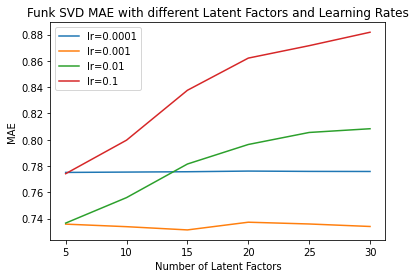

Optimal Learning Rate: 0.001
Optimal Number of Latent Factors: 15


In [21]:
for lr in mae_outputs:
	plt.plot(factors, mae_outputs[lr], label=f"lr={lr}")

plt.ylabel("MAE")
plt.xlabel("Number of Latent Factors")
plt.xticks(factors)
plt.title("Funk SVD MAE with different Latent Factors and Learning Rates")
plt.legend()
plt.show()

opt_lr, lr_n_factors = min(mae_outputs.items(), key=lambda x: min(x[1]))
opt_n_factor = factors[lr_n_factors.index(min(lr_n_factors))]

print(f"Optimal Learning Rate: {opt_lr}")
print(f"Optimal Number of Latent Factors: {opt_n_factor}")


## Predict with Funk SVD

For this predictions, it will be used the optimal hyperparameters calculated previously for the SVD.

In [22]:
%%capture
# Train SVD with optimal hyperparameters calculated previously
svd = SVD(lr=0.01, n_epochs=100, n_factors=10, early_stopping=False,
			shuffle=False, min_rating=1, max_rating=5)

svd.fit(X=train, X_val=val)

# Predict ratings of a user for rated and non rated movies

In order to make a prediction, it is necessary to follow the Funk SVD algorithm training methodology, so first it initiates the prediction with the global mean rating, then it adds the adjusted bias for both the user and the movie, and finally, add the dot product of the latent factors of the user and the movie.

In this example, it is realized a prediction for a user and a movie that are in the training data, and then another that are in the testing data. With this it is possible to visualize that even though the data wasn't used for training, the model is still able to make good predictions for unseen data.

In [23]:
user_id_rated = train.iloc[0, :].u_id
movie_id_rated = train.iloc[0, :].i_id

user_id_unrated = test.iloc[0, :].u_id
movie_id_unrated = test.iloc[0, :].i_id

def predict(svd, user_id, movie_id):
	# initialize prediction to global mean rating
	pred = svd.global_mean_

	# getting index assigned to the user id by the Funk SVD
	u_ix = svd.user_mapping_[user_id]

	# adding the bias associated with this user id
	pred += svd.bu_[u_ix]

	# getting index assigned to the movie id by the Funk SVD
	i_ix = svd.item_mapping_[movie_id]

	# adding the bias associated with the movie id
	pred= pred + svd.bi_[i_ix]

	# dot product between the associated user's and movie's latent factors
	pred+= np.dot(svd.pu_[u_ix], svd.qi_[i_ix])

	return pred

print(f"Rating prediction for user {user_id_rated} of a rated movie (in training set) {movie_id_rated}: {predict(svd, user_id_rated, movie_id_rated):0.1f},\
 Actual Rating: {ratings_matrix.iloc[user_id_rated - 1, movie_id_rated - 1]}")
print(f"Rating prediction for user {user_id_unrated} of a unrated movie (not in training set) {movie_id_unrated}:\
 {predict(svd, user_id_unrated, movie_id_unrated):0.1f},\
 Actual Rating: {ratings_matrix.iloc[user_id_unrated - 1, movie_id_unrated - 1]}")

Rating prediction for user 707 of a rated movie (in training set) 815: 2.8, Actual Rating: 2.0
Rating prediction for user 259 of a unrated movie (not in training set) 200: 4.5, Actual Rating: 4.0


## Similarity Analysis

Filtering and recommending based on information given by other users is known as collaborative filtering.

It is possible to create a simple recommending system, based on the assumption that people with similar movie tastes are most likely to give similar movie ratings.

So, for example, if a person is looking for a new movie and it has watched The Matrix, we can use a method, that is explained more in detail below, that can recommend movies with a similar rating pattern to The Matrix.

We created a method that calculates the cosine similarity with movies latent factors, sorts them by most similar and return the top N.

In [24]:
def top_cosine_similarity(data, item_id, top_n=5):
    index = item_id - 1 #Ids starts from 1 in the dataset
    row = data[index, :]
    magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
    similarity = np.dot(row, data.T) / (magnitude[index] * magnitude)
    sort_indexes = np.argsort(-similarity)
    return sort_indexes[:top_n]

# Function to print top N similar movies
def print_similar_movies(movie_data, movie_id, top_indexes):
    print('Recommendations for {0}: \n'.format(
        movie_data[movie_data.movie_id == movie_id].title.values[0]))
    for id in top_indexes + 1:
        print(movie_data[movie_data.movie_id == id].title.values[0])

movie_id = 1
top_n = 5

# using the truncated svd
top_indexes_movies = top_cosine_similarity(VT, movie_id, top_n)
print_similar_movies(movies, movie_id, top_indexes_movies)

# using funk svd
top_indexes_movies = top_cosine_similarity(svd.qi_, movie_id, top_n)
print_similar_movies(movies, movie_id, top_indexes_movies)

Recommendations for Toy Story (1995): 

Toy Story (1995)
Billy Madison (1995)
Aristocats, The (1970)
Much Ado About Nothing (1993)
GoldenEye (1995)
Recommendations for Toy Story (1995): 

Toy Story (1995)
Little Princess, A (1995)
Albino Alligator (1996)
Howling, The (1981)
Stag (1997)


The same process can be applied to users. This way we could recommend similar users, that may have interests in the same type of movies.

In this method we use the users' associated latent factors.

In [25]:
# Function to get formated user data
def form_user_data(user_data, user_id):
    user = user_data[user_data.user_id == user_id]
    return f"[Id: {user.user_id.values[0]}, Age: {user.age.values[0]}, Sex: {user.sex.values[0]}, Occupation: {user.occupation.values[0]}]"

# Function to print top N similar users
def print_similar_users(user_data, user_id, top_indexes):
    print('Recommendations for user {0}: \n'.format(
        form_user_data(user_data, user_id)
    ))
    for id in top_indexes + 1:
        print(form_user_data(user_data, id))

user_id = 1
top_indexes_users = top_cosine_similarity(U, user_id, top_n)
print_similar_users(users, user_id, top_indexes_users)

# using funk svd
top_indexes_users = top_cosine_similarity(svd.pu_, user_id, top_n)
print_similar_users(users, user_id, top_indexes_users)

Recommendations for user [Id: 1, Age: 24, Sex: M, Occupation: technician]: 

[Id: 1, Age: 24, Sex: M, Occupation: technician]
[Id: 463, Age: 48, Sex: F, Occupation: healthcare]
[Id: 894, Age: 47, Sex: M, Occupation: educator]
[Id: 622, Age: 25, Sex: M, Occupation: programmer]
[Id: 290, Age: 40, Sex: M, Occupation: engineer]
Recommendations for user [Id: 1, Age: 24, Sex: M, Occupation: technician]: 

[Id: 1, Age: 24, Sex: M, Occupation: technician]
[Id: 296, Age: 43, Sex: F, Occupation: administrator]
[Id: 278, Age: 37, Sex: F, Occupation: librarian]
[Id: 731, Age: 41, Sex: F, Occupation: educator]
[Id: 790, Age: 27, Sex: M, Occupation: technician]


# Graphic Similarity Analysis

It is also possible to visualize the similarity between items on a graphic, by taking the first two latent factors corresponding to the movies and displaying the movies on that plane. 

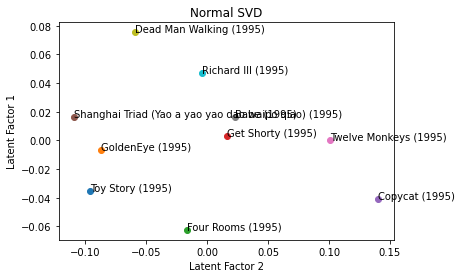

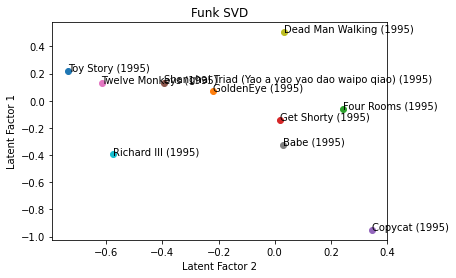

In [26]:
for i in range(10):
	plt.plot(VT[i,0], VT[i,1], 'o')
	plt.annotate(movies[movies.movie_id == i+1].title.values[0], (VT[i,0], VT[i,1]))

plt.ylabel("Latent Factor 1")
plt.xlabel("Latent Factor 2")
plt.title("Normal SVD")
plt.show()

for i in range(10):
	plt.plot(svd.qi_[i,0], svd.qi_[i,1], 'o')
	plt.annotate(movies[movies.movie_id == i+1].title.values[0], (svd.qi_[i,0], svd.qi_[i,1]))

plt.ylabel("Latent Factor 1")
plt.xlabel("Latent Factor 2")
plt.title("Funk SVD")
plt.show()